# Mapping Gene Expression Data to CNV Tables

## Overview
This notebook maps gene expression data to the corresponding gene-level copy number variation table through the gene name. This is done to add gene expression to the ground truth table as a feature. Gene expression data is taken from the statistics files, which are generated through preprocessing dense matrices.

## Workflow:

1. Gene-level CNV data is retrieved from its original file.
2. Gene names in the CNV table are matched (joined) to those in the corresponding stats file.
3. The expression data for genes is identified in the stats file (Sum, Mean, Variance columns) and added to the CNV table.

Each joined table is then appended to a larger table that consists of all available sample data.

Import libraries

In [1]:
import pandas as pd
import numpy as np
import requests
from google.colab import files # for upload/download if needed

### Case ID mapping

Get the mapping file linking Case IDs, gene-level CNV tables, and gene expression statistics. Samples without a corresponding dense matrix are dropped because no gene expression data can be pulled from them.

In [2]:
map_df = pd.read_csv('https://raw.githubusercontent.com/LaraLim/cnv-supervised-learning/refs/heads/main/mapping/stats_mapping.csv')

# list to store indices of rows with no stats (.txt file instead of .csv)
rows_to_drop = []

for index, row in enumerate(map_df['Stats_file']):
    fname = row.split(".")[0]  # get file name prefix
    url = f'https://github.com/LaraLim/cnv-supervised-learning/tree/main/gene_statistics/{fname}.csv'
    response = requests.get(url) # GET request looking for a the csv file

    # if the file not found, add row index to list
    if response.status_code == 404:
        rows_to_drop.append(index)

# drop all recorded rows by index
map_df = map_df.drop(index=rows_to_drop).reset_index(drop=True)
print(f'rows to drop: {rows_to_drop}')

rows to drop: [21, 23]


### CNV data

Retrieve gene-level CNV data for all cases and store in a dataframe dictionary

In [3]:
# dictionary of CNV dataframes identifiable by case ID
cnv_dfs = {}

# dataframe to track CNV data across all samples
combined_cnv_df = pd.DataFrame()
combined_cnv_df['CaseID'] = ''

# first sample
filename = map_df['CNV_file'][0]
url = f'https://raw.githubusercontent.com/LaraLim/cnv-supervised-learning/refs/heads/main/ground_truth_cnv/{filename}'
df = pd.read_csv(url, sep='\t')
numRows = df.shape[0]

for filename in map_df['CNV_file']:

    # get the case id
    case_id = map_df[map_df['CNV_file'] == filename]['CaseID'].values[0]
    df['CaseID'] = case_id

    url = f'https://raw.githubusercontent.com/LaraLim/cnv-supervised-learning/refs/heads/main/ground_truth_cnv/{filename}'
    df = pd.read_csv(url, sep='\t')

    # set CNV statuses based on their values
    df['status'] = 'normal'
    df.loc[df['copy_number'] > 2, 'status'] = 'amplified'
    df.loc[df['copy_number'] < 2, 'status'] = 'deleted'

    # move the position of the copy number column to the last column
    copy_number = df.pop('copy_number')
    df['copy_number_target'] = copy_number

    # drop rows without CNV values and create a fresh copy
    df = df.dropna(subset=['copy_number_target']).copy()

    cnv_dfs[case_id] = df # add dataframe to dictionary

    combined_cnv_df['CaseID'] = case_id
    combined_cnv_df = pd.concat([combined_cnv_df, df], ignore_index=True) # append the dataframe to the combined one

print(f'combined_cnv_df has {combined_cnv_df.shape[0]} rows')
display(combined_cnv_df.head())

combined_cnv_df has 2111587 rows


,CaseID,gene_id,gene_name,chromosome,start,end,min_copy_number,max_copy_number,status,copy_number_target
0,C3N-03188-02,ENSG00000223972.5,DDX11L1,chr1,11869.0,14409.0,4.0,4.0,amplified,4.0
1,C3N-03188-02,ENSG00000227232.5,WASH7P,chr1,14404.0,29570.0,4.0,4.0,amplified,4.0
2,C3N-03188-02,ENSG00000278267.1,MIR6859-1,chr1,17369.0,17436.0,4.0,4.0,amplified,4.0
3,C3N-03188-02,ENSG00000243485.5,MIR1302-2HG,chr1,29554.0,31109.0,4.0,4.0,amplified,4.0
4,C3N-03188-02,ENSG00000284332.1,MIR1302-2,chr1,30366.0,30503.0,4.0,4.0,amplified,4.0


### Gene expression statistics

Retrieve gene expression statistics (for all cases) derived from dense matrices and store in a dataframe dictionary. Statistics include the sum, mean, and variance for gene expression.

In [4]:
# dictionary of gene expression stat dataframes identifiable by case ID
ge_dfs = {}

# dataframe to track gene expression stats across all samples
combined_ge_df = pd.DataFrame()

# first sample
filename = map_df['Stats_file'][0]
url = f'https://raw.githubusercontent.com/LaraLim/cnv-supervised-learning/refs/heads/main/gene_statistics/{filename}'
df = pd.read_csv(url, delimiter=',')
numRows = df.shape[0]

for filename in map_df['Stats_file']:

    # get the case id
    case_id = map_df[map_df['Stats_file'] == filename]['CaseID'].values[0]

    url = f'https://raw.githubusercontent.com/LaraLim/cnv-supervised-learning/refs/heads/main/gene_statistics/{filename}'
    df = pd.read_csv(url, delimiter=',')

    ge_dfs[case_id] = df # add dataframe to dictionary
    combined_ge_df = pd.concat([combined_ge_df, df], ignore_index=True) # append the dataframe to the combined one

print(f'combined_ge_df has {combined_ge_df.shape[0]} rows')
display(combined_ge_df.head())

combined_ge_df has 1316509 rows


,Gene,Sum,Mean,Variance
0,WASH7P,0.006084,4.167978e-07,1.770619e-10
1,MIR1302-2HG,0.002205,1.510508e-07,3.707889e-11
2,OR4F5,0.000527,3.610975e-08,7.165660e-12
3,AL627309.1,0.009764,6.688604e-07,4.153622e-10
4,AL627309.6,0.000800,5.478004e-08,2.699976e-11


### Combined data

Check dictionaries for CNV and gene stat tables

In [5]:
print(f'CNV tables:\n{cnv_dfs.keys()}\n')
print(f'Gene expression stat tables:\n{ge_dfs.keys()}')

CNV tables:
dict_keys(['C3L-00359-01', 'C3L-00606-01', 'C3L-00606-02', 'C3L-00606-03', 'C3L-01287-01', 'C3L-01287-03', 'C3L-01953-01', 'C3L-02705-71', 'C3L-02858-01', 'C3L-03405-01', 'C3L-03968-01', 'C3N-00148-01', 'C3N-00148-02', 'C3N-00148-03', 'C3N-00148-04', 'C3N-00149-02', 'C3N-00149-03', 'C3N-00149-04', 'C3N-00439-02', 'C3N-00662-03', 'C3N-01175-01', 'C3N-01270-02', 'C3N-01798-01', 'C3N-01814-01', 'C3N-01815-01', 'C3N-01816-01', 'C3N-01904-02', 'C3N-02181-02', 'C3N-02188-03', 'C3N-02190-01-02', 'C3N-02769-02', 'C3N-02783-05', 'C3N-02784-01-03', 'C3N-03184-02', 'C3N-03186-01', 'C3N-03188-02'])

Gene expression stat tables:
dict_keys(['C3L-00359-01', 'C3L-00606-01', 'C3L-00606-02', 'C3L-00606-03', 'C3L-01287-01', 'C3L-01287-03', 'C3L-01953-01', 'C3L-02705-71', 'C3L-02858-01', 'C3L-03405-01', 'C3L-03968-01', 'C3N-00148-01', 'C3N-00148-02', 'C3N-00148-03', 'C3N-00148-04', 'C3N-00149-02', 'C3N-00149-03', 'C3N-00149-04', 'C3N-00439-02', 'C3N-00662-03', 'C3N-01175-01', 'C3N-01270-02', '

Merge the dataframes on `gene_name` from `cnv_dfs` and `Gene` from `ge_dfs`. Use left join to preserve all rows from `cnv_dfs`. These merged dataframes are then appended to a master dataframe (`combined_df`) for analysis.

Combined data (separate per sample) is also uploaded to the `dataset` directory on the project GitHub for future reference.

In [11]:
# dataframe to track joined data across all samples
combined_df = pd.DataFrame()
combined_df['CaseID'] = ''

# dictionary of joined dataframes identifiable by case ID
j_dfs = {}

for case_id in map_df['CaseID']:
    # check if case ID exists in both dictionaries
    if case_id not in cnv_dfs or case_id not in ge_dfs:
        print(f"\n[WARNING] skipping case_id {case_id}; missing from one or both dictionaries\n")
        continue

    # merge only if case ID exists in both dictionaries
    joined_df = pd.merge(cnv_dfs[case_id], ge_dfs[case_id], left_on='gene_name', right_on='Gene', how='left')

    # rename columns in merged dataframe
    joined_df = joined_df.rename(columns={'Sum': 'sum_gene_expr', 'Mean': 'mean_gene_expr', 'Variance': 'variance_gene_expr'})

    joined_df = joined_df.drop(columns='Gene')  # drop redundant Gene column

    # fill any gene stat NaN values columns with 0
    joined_df[['sum_gene_expr', 'mean_gene_expr', 'variance_gene_expr']] = joined_df[['sum_gene_expr', 'mean_gene_expr', 'variance_gene_expr']].fillna(0)

    # columns for normalized stats
    joined_df['sum_gene_expr_normalized'] = np.log1p(joined_df['sum_gene_expr'])
    joined_df['mean_gene_expr_normalized'] = np.log1p(joined_df['mean_gene_expr'])
    joined_df['variance_gene_expr_normalized'] = np.log1p(joined_df['variance_gene_expr'])

    # if CaseID is not in joined_df, add it
    if 'CaseID' not in joined_df.columns:
        joined_df.insert(0, 'CaseID', case_id)  # insert as first (leftmost) column
    else:
        case_id_col = joined_df.pop('CaseID')
        joined_df.insert(0, 'CaseID', case_id_col) # move CaseID to be the first column

    combined_df = pd.concat([combined_df, joined_df], ignore_index=True) # append the dataframe to the combined one
    j_dfs[case_id] = joined_df # add dataframe to dictionary

print(f'combined_df has {combined_df.shape[0]} rows')
display(combined_df.head())

combined_df has 2111587 rows


,CaseID,gene_id,gene_name,chromosome,start,end,min_copy_number,max_copy_number,status,copy_number_target,sum_gene_expr,mean_gene_expr,variance_gene_expr,sum_gene_expr_normalized,mean_gene_expr_normalized,variance_gene_expr_normalized
0,C3L-00606-01,ENSG00000223972.5,DDX11L1,chr1,11869.0,14409.0,4.0,4.0,amplified,4.0,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
1,C3L-00606-01,ENSG00000227232.5,WASH7P,chr1,14404.0,29570.0,4.0,4.0,amplified,4.0,0.006084,4.167978e-07,1.770619e-10,0.006066,4.167977e-07,1.770619e-10
2,C3L-00606-01,ENSG00000278267.1,MIR6859-1,chr1,17369.0,17436.0,4.0,4.0,amplified,4.0,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
3,C3L-00606-01,ENSG00000243485.5,MIR1302-2HG,chr1,29554.0,31109.0,4.0,4.0,amplified,4.0,0.002205,1.510508e-07,3.707889e-11,0.002203,1.510508e-07,3.707889e-11
4,C3L-00606-01,ENSG00000284332.1,MIR1302-2,chr1,30366.0,30503.0,4.0,4.0,amplified,4.0,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00


Computed feature: deviation of gene expression stats from the overall mean across samples

In [12]:
# find the means of sum_gene_expr_normalized
gene_sum_normalized_means = combined_df.groupby('gene_name')['sum_gene_expr_normalized'].mean()

# find the means of mean_gene_expr_normalized
gene_mean_normalized_means = combined_df.groupby('gene_name')['mean_gene_expr_normalized'].mean()

# find the means of variance_gene_expr_normalized
gene_variance_normalized_means = combined_df.groupby('gene_name')['variance_gene_expr_normalized'].mean()

# calculate the deviations
combined_df['dev_gene_expr_normalized_mean'] = combined_df['gene_name'].map(gene_sum_normalized_means) - combined_df['sum_gene_expr_normalized']
combined_df['dev_mean_gene_expr_normalized_mean'] = combined_df['gene_name'].map(gene_mean_normalized_means) - combined_df['mean_gene_expr_normalized']
combined_df['dev_variance_gene_expr_normalized_mean'] = combined_df['gene_name'].map(gene_variance_normalized_means) - combined_df['variance_gene_expr_normalized']

# move copy_number_target to be the end (rightmost) column
copy_number_col = combined_df.pop('copy_number_target')
combined_df['copy_number_target'] = copy_number_col

print(f'combined_df has {combined_df.shape[0]} rows')
display(combined_df.head())

combined_df has 2111587 rows


,CaseID,gene_id,gene_name,chromosome,start,end,min_copy_number,max_copy_number,status,sum_gene_expr,mean_gene_expr,variance_gene_expr,sum_gene_expr_normalized,mean_gene_expr_normalized,variance_gene_expr_normalized,dev_gene_expr_normalized_mean,dev_mean_gene_expr_normalized_mean,dev_variance_gene_expr_normalized_mean,copy_number_target
0,C3L-00606-01,ENSG00000223972.5,DDX11L1,chr1,11869.0,14409.0,4.0,4.0,amplified,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000041,2.518656e-09,1.969888e-12,4.0
1,C3L-00606-01,ENSG00000227232.5,WASH7P,chr1,14404.0,29570.0,4.0,4.0,amplified,0.006084,4.167978e-07,1.770619e-10,0.006066,4.167977e-07,1.770619e-10,0.009837,1.149426e-06,8.159471e-10,4.0
2,C3L-00606-01,ENSG00000278267.1,MIR6859-1,chr1,17369.0,17436.0,4.0,4.0,amplified,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,4.0
3,C3L-00606-01,ENSG00000243485.5,MIR1302-2HG,chr1,29554.0,31109.0,4.0,4.0,amplified,0.002205,1.510508e-07,3.707889e-11,0.002203,1.510508e-07,3.707889e-11,-0.001485,-7.554026e-08,-7.623837e-12,4.0
4,C3L-00606-01,ENSG00000284332.1,MIR1302-2,chr1,30366.0,30503.0,4.0,4.0,amplified,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,4.0


Optional split of dataset into tables for each sample. Export to CSV file and download:

In [13]:
for case_id in map_df['CaseID']:
    case_df = combined_df[combined_df['CaseID'] == case_id] # separate out by case ID

    new_file_name = f'{case_id}.csv'
    case_df.to_csv(new_file_name, index=False)
    files.download(new_file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Visualization

Plotting function for the distributions of gene expression statistics: sum, mean, and variance.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_histograms(df, columns, name):
    # create subplots
    fig, axes = plt.subplots(len(columns), 2, figsize=(12, 5 * len(columns)))
    fig.suptitle(f'Gene Expression Statistic Histograms for {name}')

    for i, column in enumerate(columns):
        # plot original data
        axes[i, 0].hist(df[column].dropna(), bins=20, color='skyblue', edgecolor='black')
        axes[i, 0].set_title(f'Original {column}')
        axes[i, 0].set_ylabel('Frequency')
        axes[i, 0].set_xlabel(column)

        # log transform the data
        log_column = f'log_{column}'
        df[log_column] = np.log(df[column] + 1e-10)  # Add a small constant for zero values

        # plot log-transformed data
        axes[i, 1].hist(df[log_column].dropna(), bins=20, color='salmon', edgecolor='black')
        axes[i, 1].set_title(f'Log Transformed {column}')
        axes[i, 1].set_ylabel('Frequency')
        axes[i, 1].set_xlabel(log_column)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

Plot the gene expression statistics for several sample dataframes

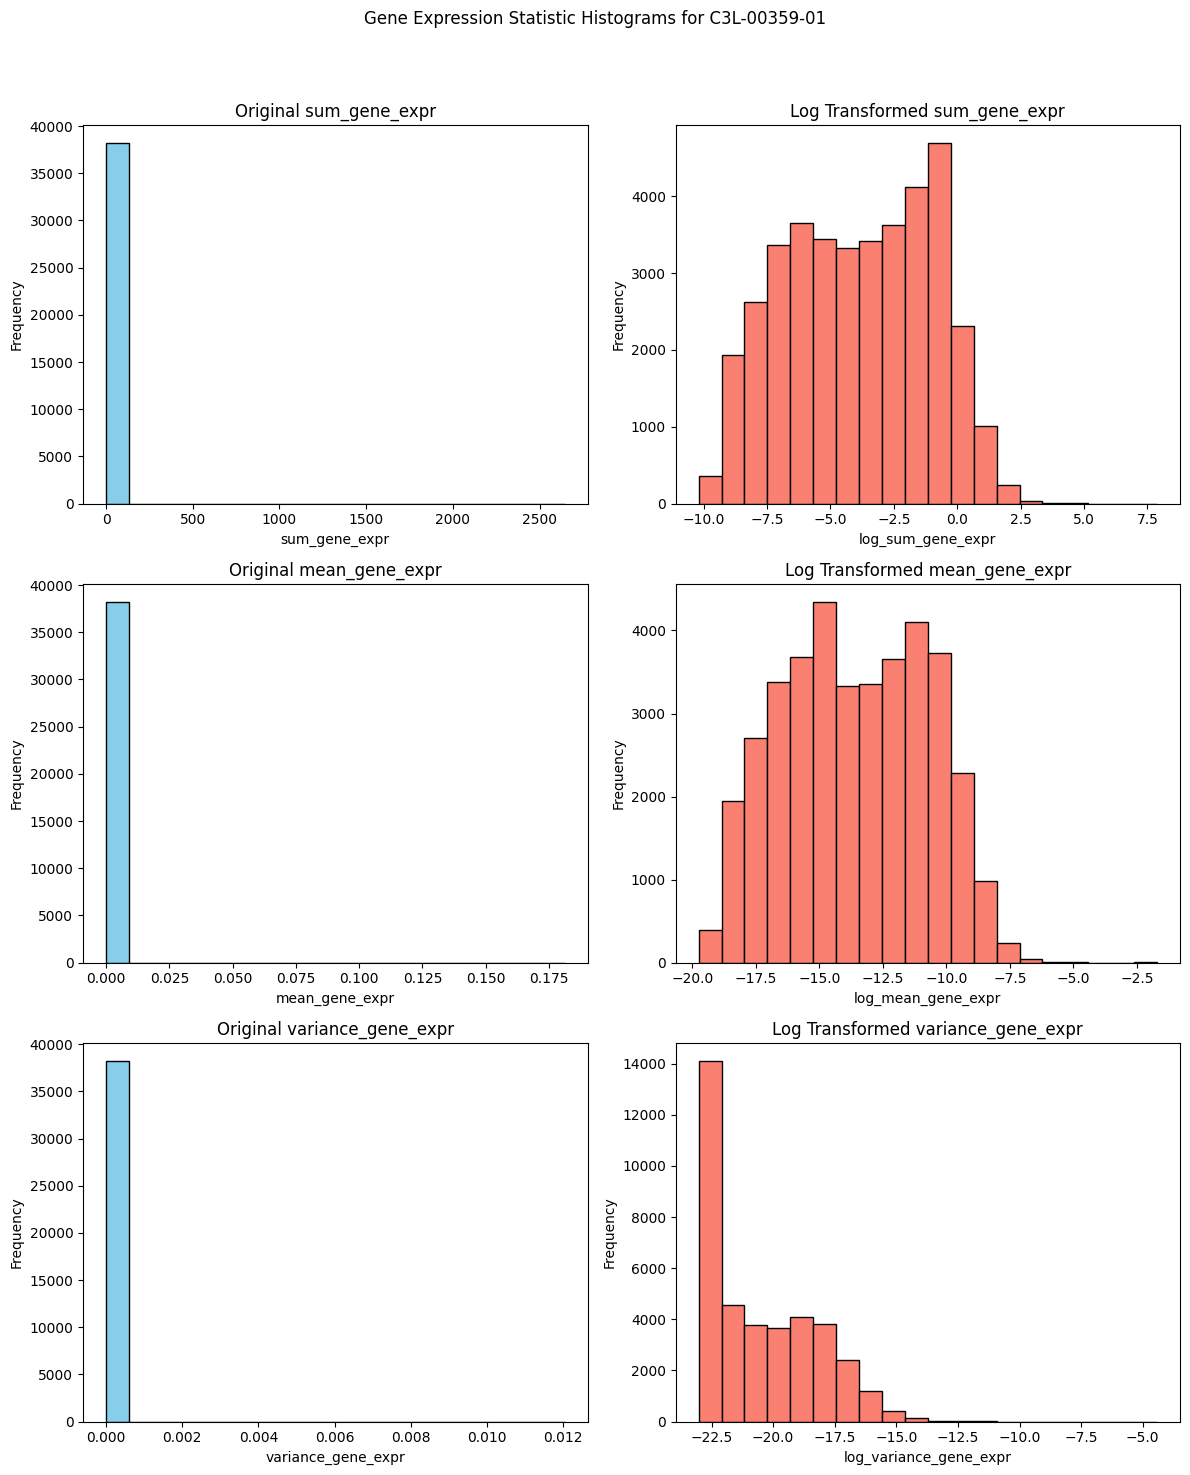

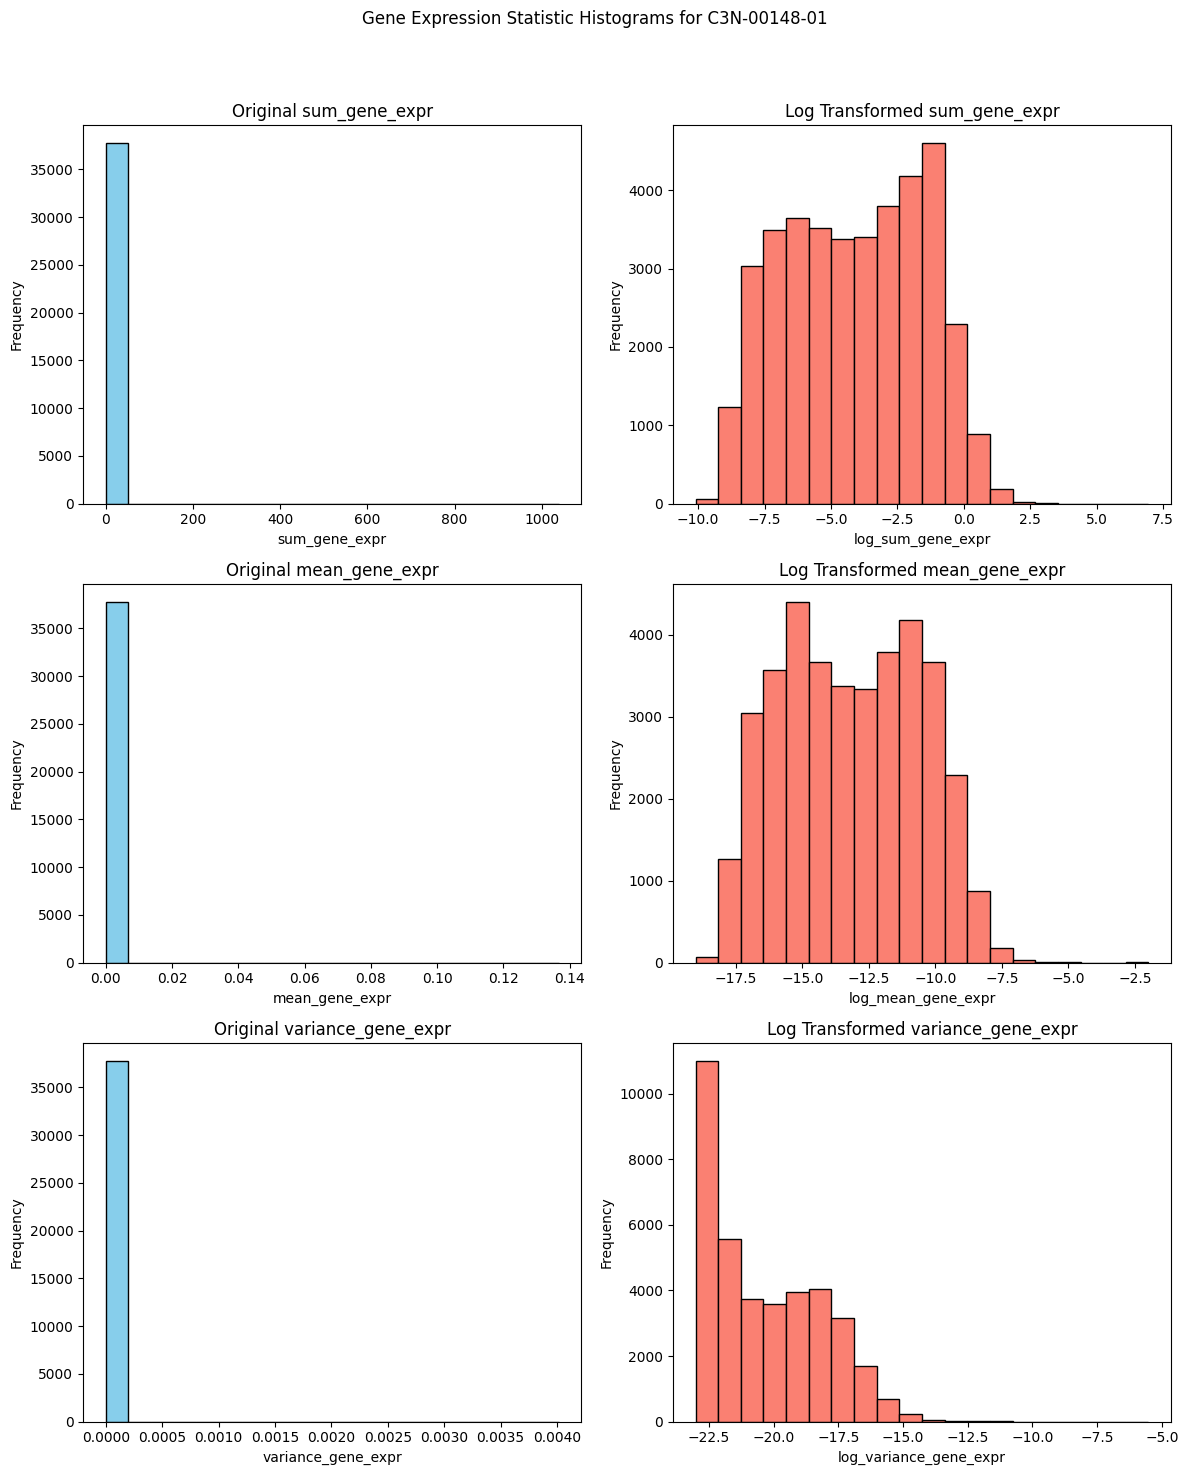

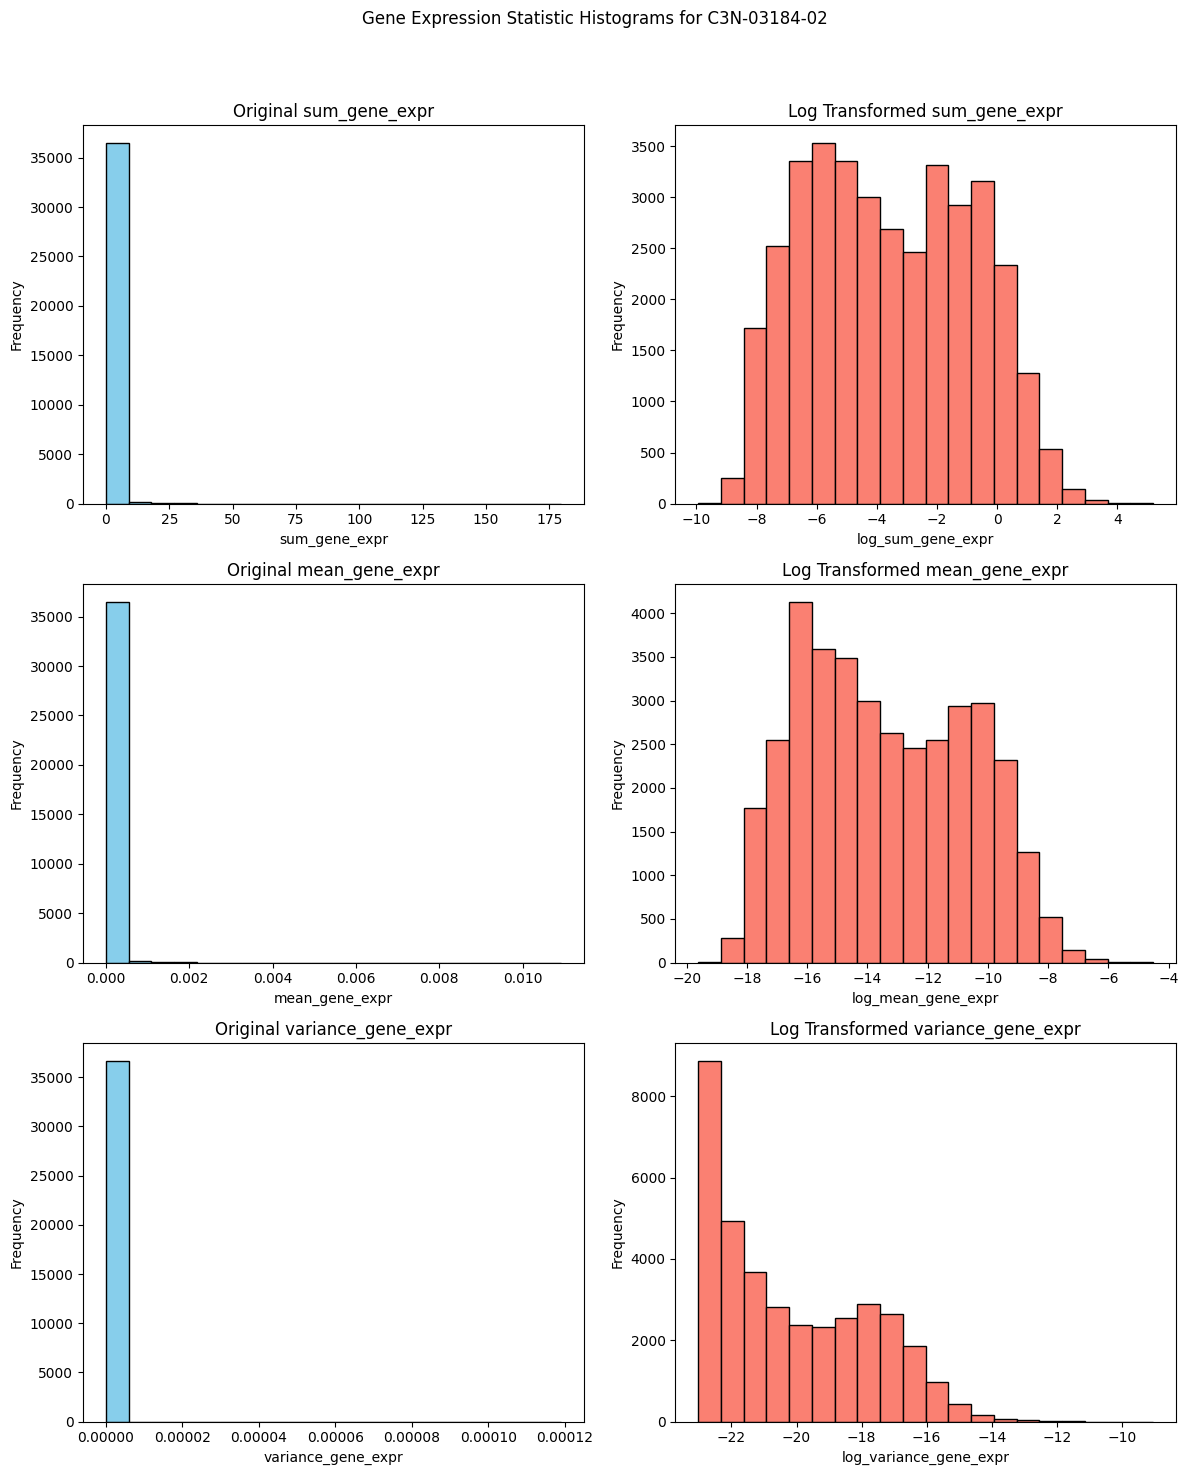

In [ ]:
plot_cols = ['sum_gene_expr', 'mean_gene_expr', 'variance_gene_expr']
plot_histograms(j_dfs['C3L-00359-01'], plot_cols, 'C3L-00359-01')

plot_cols = ['sum_gene_expr', 'mean_gene_expr', 'variance_gene_expr']
plot_histograms(j_dfs['C3N-00148-01'], plot_cols, 'C3N-00148-01')

plot_cols = ['sum_gene_expr', 'mean_gene_expr', 'variance_gene_expr']
plot_histograms(j_dfs['C3N-03184-02'], plot_cols, 'C3N-03184-02')

## Experimental

Interquartile range is used to clean the outliers from the combined dataframe.

In [ ]:
# helper function to remove outliers via IQR
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# remove outliers for each gene expression metric
combined_df_cleaned = combined_df.copy()  # create a copy not to modify the original dataframe
for column in ['sum_gene_expr', 'mean_gene_expr', 'variance_gene_expr']:
    combined_df_cleaned = remove_outliers_iqr(combined_df_cleaned, column)

Plot the distributions for gene expression statistics: sum, mean, and variance.

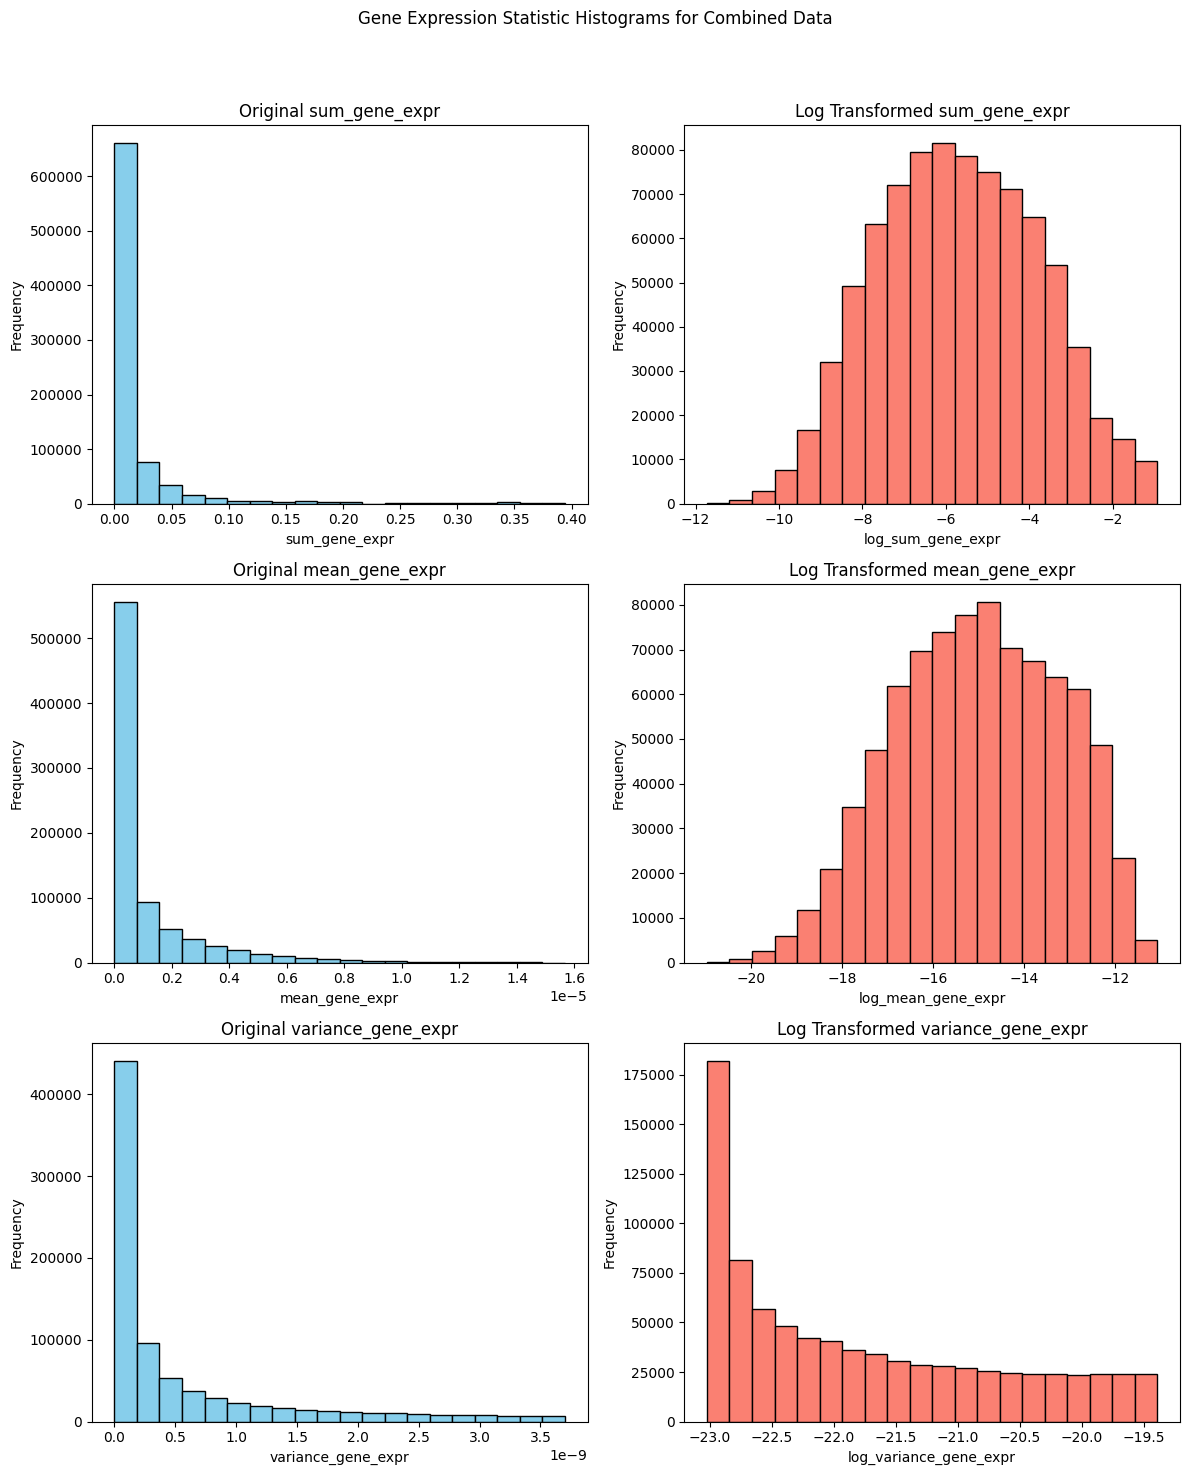

In [ ]:
plot_cols = ['sum_gene_expr', 'mean_gene_expr', 'variance_gene_expr']
plot_histograms(combined_df_cleaned, plot_cols, 'Combined Data')